# Difference algorithm

A popular game consists of finding the differences between 2 images. In this project we develop an application to do the work automatically, using computer vision tools.

This is relatively simple: we align the images (registration), do some blurring (of the typical size of a difference) and compute a difference image. We then display the area with significant changes.

## Introduction

The goal is to build a mobile application capable of detecting a pair of images from a physical paper, finding the differences and displaying the found differences in augmented reality. The core algorithm will superimpose the two images and find the areas with significant differences. 

We will start with the core algorithm in ideal conditions and progressively increase the complexity:
1. we start with scanned images, so they are flat, of equal size, and with little noise. We register (align) the images using translation and run the difference algorithm. The differences are displayed as rectangular contours.
2. In a second step, we find the contours automatically, hence the two subimages, from a single image (i.e. scanning the page or taking a photo). We allow for projective distortion and other sources of noise.
3. we run the algorithm on a video stream
4. we port it on a mobile device


In [138]:
## Preamble (import ing the required libraries)
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, mean_squared_error

import diff_spotter as ds

from importlib import reload

# for plotting
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25})

# plt.style.use('seaborn')
plt.style.use('seaborn-whitegrid')
plt.rc('pdf',fonttype=42)

import seaborn as sns
sns.mpl.rc('figure', figsize = (14, 8))
sns.set_context(
    'notebook', font_scale=2.5, rc={'lines.linewidth': 2.5})

## 1. Image registration

To do run the difference algorighm, we need the image to be perfectly aligned. Here we simply load 2 images that have been previsouly aligned (registered) as described in another notebook.

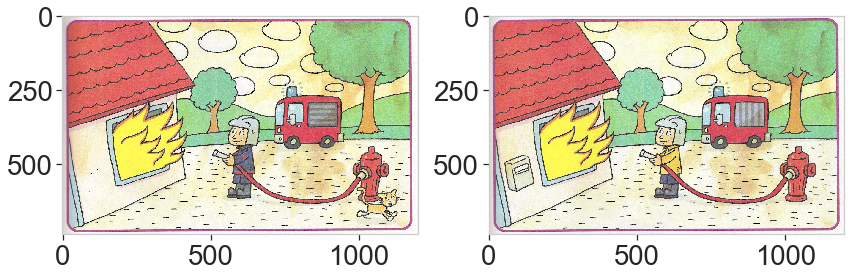

In [139]:
reload(ds)

# Read and display the 2 images (images have already been aligned)

# 1, 2, 3, 6, or 8
image_name = 'data/diff6'

img_a = cv2.imread(image_name+'_a_aligned.png')
img_b = cv2.imread(image_name+'_b_aligned.png')

ds.display_2img(img_a, img_b, file_name='plots/ex6.png')

## 2. Blurring

We blur to eliminate the noise. The kernel should be big enough to reduce noise but small enough to keep the high frequency of the differences (or we might miss them). we expect the differences to be at least a few percents of the total size so the blurring kernel is about 2% of the width of the image

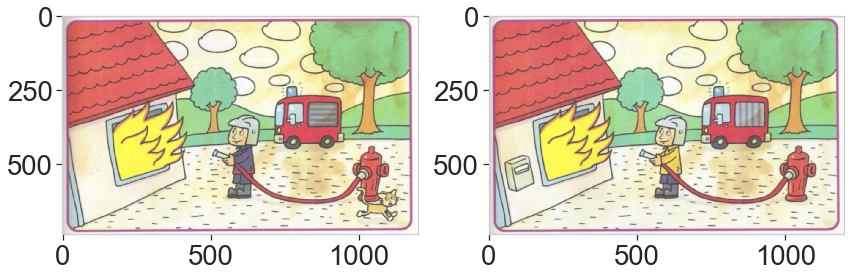

In [140]:
kernel_size = int(img_a.shape[1]/50)

# must be odd if median
kernel_size += kernel_size%2-1

img_a_blurred = cv2.GaussianBlur(img_a, (kernel_size, kernel_size), 1.5)
img_b_blurred = cv2.GaussianBlur(img_b, (kernel_size, kernel_size), 1.5)

ds.display_2img(img_a_blurred, img_b_blurred, file_name='plots/ex6_blurred.png')

## 3. Image difference

We compute the difference between the 2 images. We use a spatial version of the Structural Similarity index algorithm to compute the difference (https://en.wikipedia.org/wiki/Structural_similarity). It has the advantage of enhancing the spatially coherent image differences and is less prone to noise than a pure pixel-to-pixel difference.

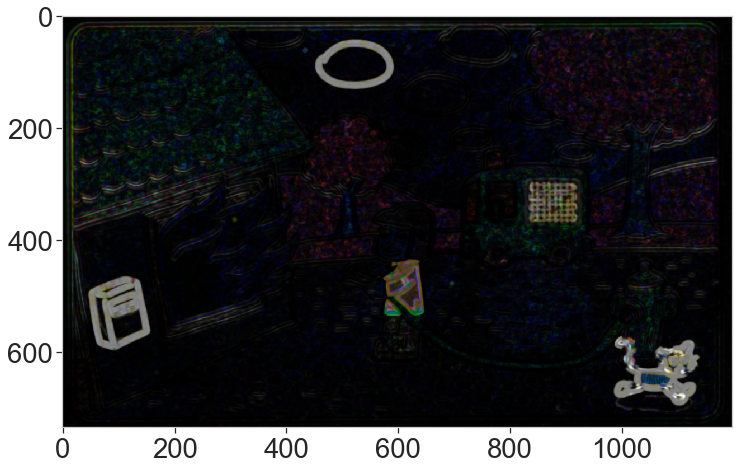

In [141]:
# compute the spatial SSIM difference
ssim = True

if ssim:
    score, diff_ssim = structural_similarity(
        img_a_blurred, img_b_blurred,
        multichannel=True, full=True, gaussian_weights=True)
    # the diff is the opposite of the similarity
    diff = 1.0-diff_ssim
    
else:
    diff= cv2.absdiff(img_a_blurred, img_b_blurred)
    
# renormalise
diff = cv2.normalize(
    diff, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
diff = diff.astype(np.uint8)

ds.display_img(diff, file_name='plots/ex6_ssim_diff.png')



## 4. Thresholding and noise removal

We first convert the color difference image to gray levels by taking the maximum among the color channels. This is because in some difference image game, only the color change, diluting the difference signal by a factor of 3.


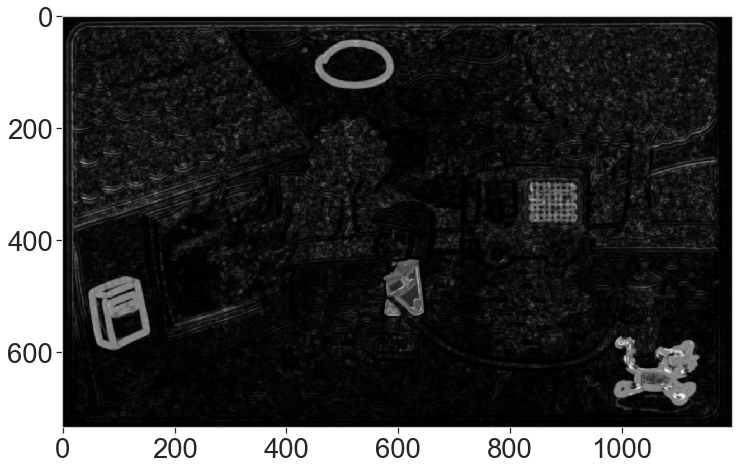

In [142]:
diff_gray = diff.max(axis=2)
ds.display_img(diff_gray)

We compute the histogram of the gray difference image, we clearly see the bump around 130 that represents the pixels where the 2 images differ. We plot the threshold value to the 5% brightest pixels.

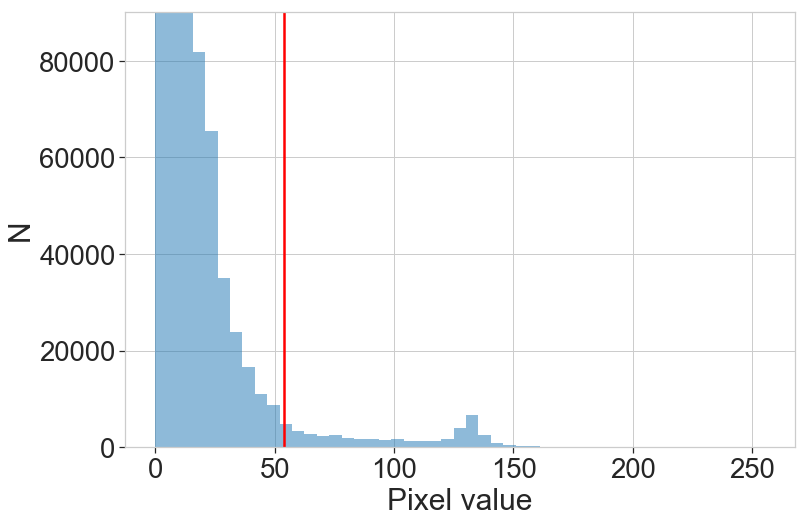

In [143]:
fig, ax = plt.subplots(figsize=(12,8))

ax.set_xlabel('Pixel value')
ax.set_ylabel('N')

ax.hist(
    diff_gray.ravel(), alpha=0.5, 
    label='All', density=False, bins=np.linspace(0,255))
#ax.set_yscale('log')
ax.set_ylim(0, 0.9e5)

min_thres = np.quantile(diff_gray, 0.95)
ax.plot([min_thres, min_thres], ax.get_ylim(),color='red')

fig.savefig('plots/ex6_hist.png', bbox_inches='tight')

None

Next, we create a binary image and remove high-frequency noise to isolate large areas with significant difference. For this, we use the morphological operations "open" and "dilate" (see https://docs.opencv.org/trunk/d9/d61/tutorial_py_morphological_ops.html), to clean noise and connect nearby bright pixels.

The threshold value is chosen so that 5% of the brightest pixels are preserved. This corresponds roughly to the expected fraction of different pixels. So this parameter is crucial. A too low threshold will increase false detections (decreases precision) and a too high threshold will miss real detections (decreases recall).


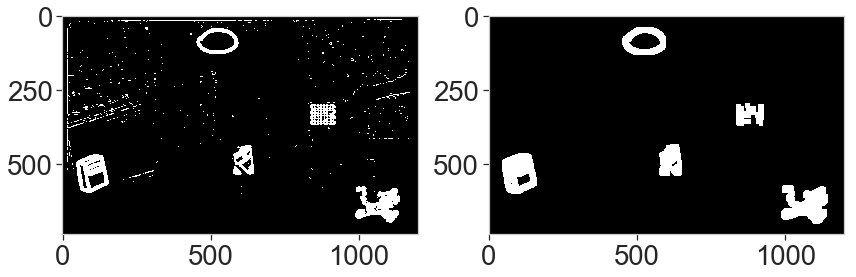

In [181]:
tresh_quantile = 0.95

# threshold is set to 5% brightest pixels 
min_thres = np.quantile(diff_gray, tresh_quantile)

# simple thresholding to create a binary image
ret, thres = cv2.threshold(diff_gray, min_thres, 255, cv2.THRESH_BINARY)

# opening operation to clean the noise with a small kernel
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thres, cv2.MORPH_OPEN, kernel, iterations=3)

# and dilatation operation to increase the size of elements 
kernel_dilate = np.ones((5,5),np.uint8)
diff_gray_thres = cv2.dilate(opening, kernel_dilate, iterations=2)

# Left: binary image, right after noise removal
ds.display_2img(thres, diff_gray_thres, file_name='plots/ex6_binary.png')

## 4. Component finding

We find the components (i.e. connected groups of pixels) and isolate them. We remove those suspected to be caused by the frame differences around the images, by removing long components exceeding the length of either half the width or half the height.

The components are sorted and we keep only the n largest. The default value is n=15, since the number of difference is between 5 and 10 and we want to be conservative in finding them: we allow a few false positives but want to capture all true differences (we maximize the recall).

In [182]:
# max number of differences
n_diff = 15

# detect connected components
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(diff_gray_thres)

# remove outer border
components = []
for i, stat in enumerate(stats):
    
    x,y,w,h = stat[0:4]
    
    if (w > img_a.shape[0]*0.5) | (h > img_a.shape[1]*0.5):
        continue
        
    components.append(stat)
    
components = np.array(components)
    
# keep the 15 largest components
try:
    # sort based on the 4th column (the area)
    sorted_indices = components[:,4].argsort()
    
    # keep the 15 largest elements
    large_components = components[sorted_indices][-n_diff:]
except:
    pass

print(retval, large_components)


6 [[  830   296    95    77  5499]
 [  573   433    78   109  7042]
 [  448    39   149    97  7770]
 [   43   463   119   139 12104]
 [  983   572   159   130 13829]]


## 5. Difference highlights

Finally, we draw red rectangles around the selected components and overlay to the original image.

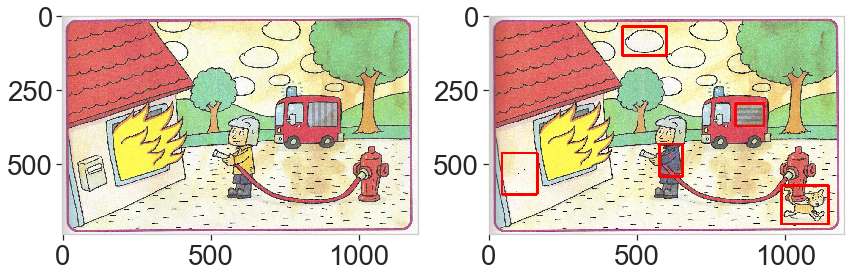

In [184]:
img_final = img_a.copy()
    
for component in large_components:
        
    x,y,w,h = component[:4]
   
    pt1 = (x,y)
    pt2 = (x+w,y+h)

    cv2.rectangle(img_final,pt1=pt1,pt2=pt2,color=(0,0,255), thickness=8)

ds.display_2img(img_b, img_final, file_name='plots/ex6_final.png')

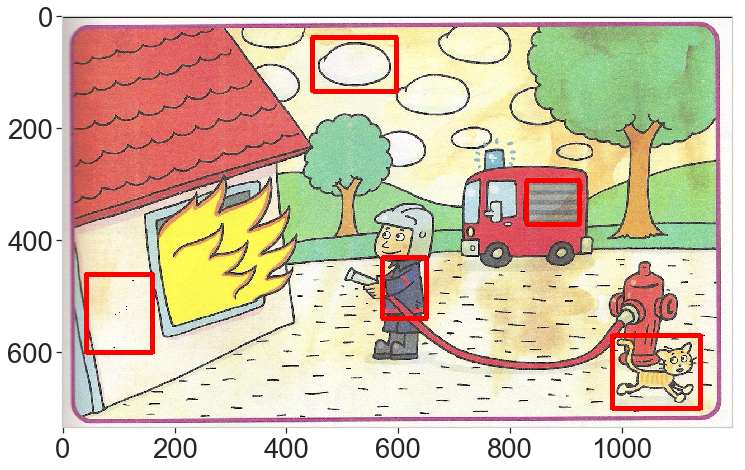

In [198]:
ds.display_img(img_final, file_name='plots/ex6_one.png')

## Full algorithm

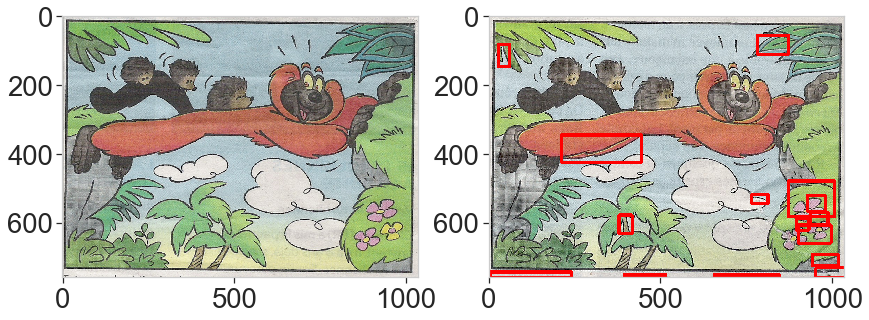

In [199]:
reload(ds)

image_name = 'data/diff1'
a = cv2.imread(image_name+'_a_aligned.png')
b = cv2.imread(image_name+'_b_aligned.png')
result = ds.find_differences(a, b, ssim=True, n_diff=15)

ds.display_2img(b, result, file_name='plots/ex1_final.png')

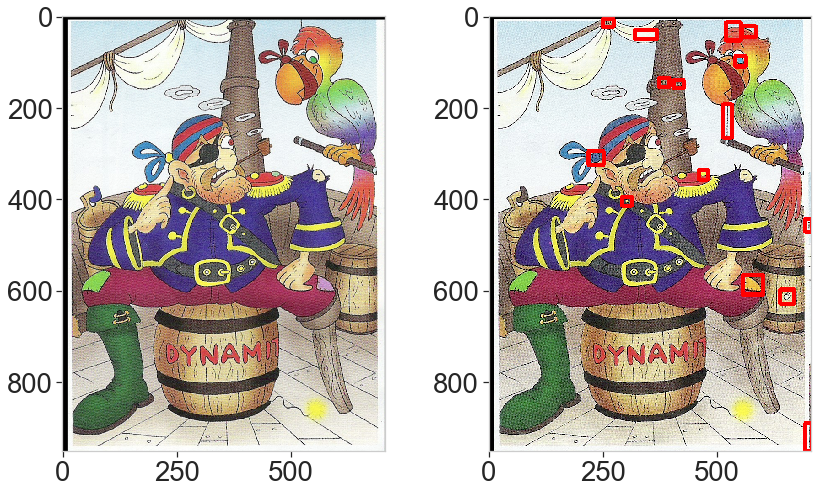

In [200]:
reload(ds)

image_name = 'data/diff2'
a = cv2.imread(image_name+'_a_aligned.png')
b = cv2.imread(image_name+'_b_aligned.png')
result = ds.find_differences(a, b)

ds.display_2img(b, result, file_name='plots/ex2_final.png')

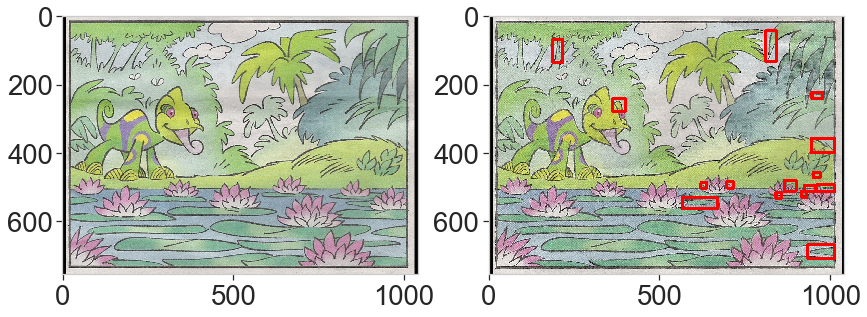

In [201]:
reload(ds)

image_name = 'data/diff3'
a = cv2.imread(image_name+'_a_aligned.png')
b = cv2.imread(image_name+'_b_aligned.png')
result = ds.find_differences(a, b)

ds.display_2img(b, result, file_name='plots/ex3_final.png')

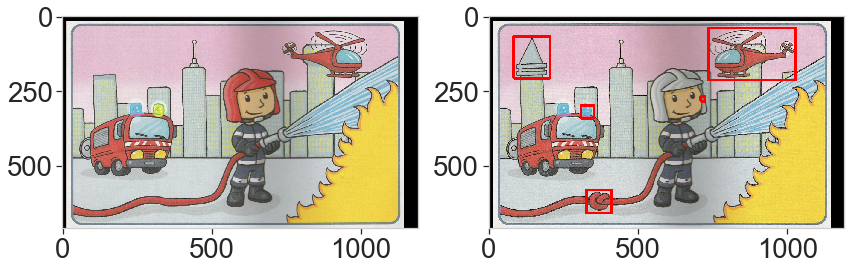

In [202]:
reload(ds)

image_name = 'data/diff8'
a = cv2.imread(image_name+'_a_aligned.png')
b = cv2.imread(image_name+'_b_aligned.png')
result = ds.find_differences(a, b)

ds.display_2img(b, result, file_name='plots/ex8_final.png')

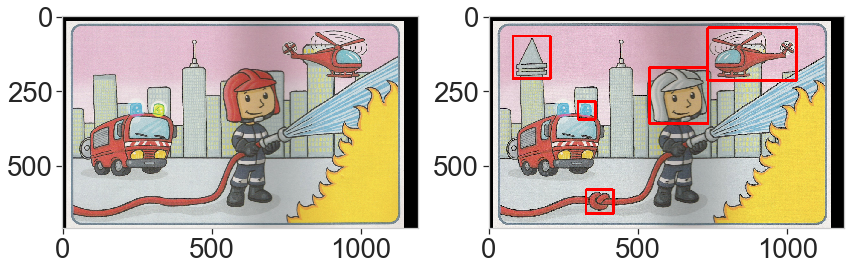

In [203]:
image_name = 'data/diff8'
a = cv2.imread(image_name+'_a_aligned.png')
b = cv2.imread(image_name+'_b_aligned.png')
result = ds.find_differences(a, b, tresh_quantile=0.90, n_diff=5)

ds.display_2img(b, result, file_name='plots/ex8_final_low_thres.png')